# Demo


The purpose of this notebook is to demostrate the functionality of seagliderOG1 functions. The test case is to convert sg015 data from the Labrador Sea in September 2004.


In [76]:
import sys
import importlib
sys.path.append('/Users/eddifying/Cloudfree/gitlab-cloudfree/seagliderOG1')
#import glidertools as gt
#importlib.reload(fetchers)
#importlib.reload(plotters)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from seagliderOG1 import fetchers
from seagliderOG1 import tools
from seagliderOG1 import plotters
import xarray as xr

#from pathlib import Path

## Load seaglider data in native format

This has three ways to load a glider dataset.

Load an example dataset using `seagliderOG1.fetchers.load_sample_dataset`

Alternatively, use your own with e.g. `ds = xr.open_dataset('/path/to/yourfile.nc')`

### Load a sample dataset

These data are hosted (currently) on dropbox.

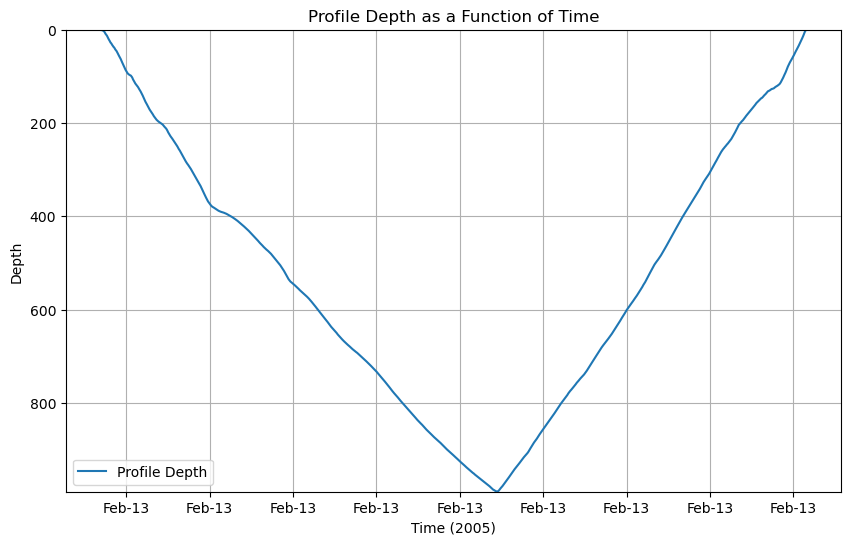

In [78]:
# List of available datasets
file_list = ['p0150500_20050213.nc', 'p0150501_20050213.nc', 'p0150502_20050214.nc', 'p0150503_20050214.nc', 'p0150504_20050215.nc'];

# Loads one dataset (p0150500_20050213.nc)
ds = fetchers.load_sample_dataset()
plotters.plot_profile_depth(ds)

### Load dataset from local machine

- For local data in the directory `input_dir`
- Creates a plot of ctd_depth against ctd_time.


/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


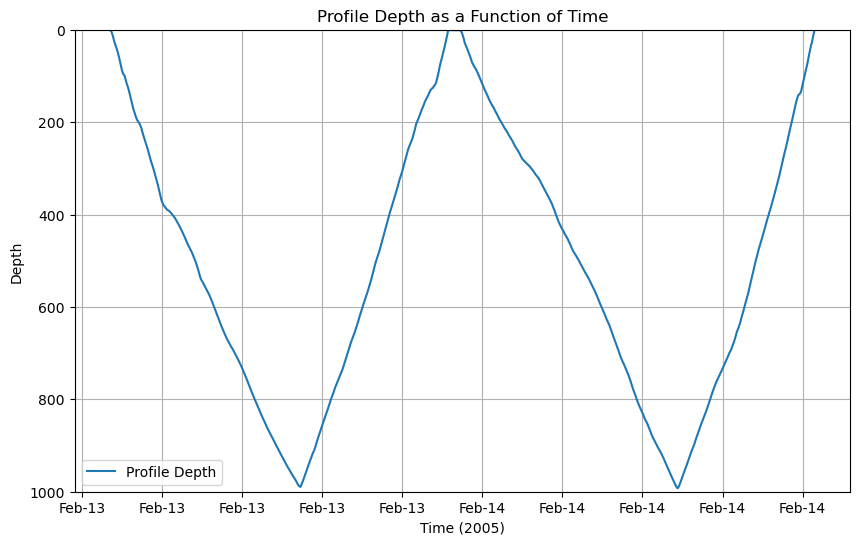

In [80]:
# Specify the input directory on your local machine
input_dir = "/Users/eddifying/Dropbox/data/sg015-ncei-download"

# Load and concatenate all datasets in the input directory
# Optionally, specify the range of profiles to load (start_profile, end_profile)
ds_all = fetchers.load_dataset_from_directory(input_dir, start_profile=500, end_profile=501)

# Simple plot of depth against time
plotters.plot_profile_depth(ds_all)

### Load data from the NCEI server

- Data from the sg015 mission in the Labrador Sea (https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0111844), dataset identifier gov.noaa.nodc:0111844.


In [ ]:
# Specify the server where data are located
server = "https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/015/20040924/"

# This was necessary to get an initial file list
# mylist = fetchers.list_files_in_https_server(server)
# fetchers.create_pooch_registry_from_directory("/Users/eddifying/Dropbox/data/sg015-ncei-download/")

# Load and concatenate all datasets from the server, optionally specifying the range of profiles to load
ds_all = fetchers.load_dataset_from_online(server, start_profile=500, end_profile=504)

# Simple plot of depth against time
plotters.plot_profile_depth(ds_all)

## Start to think about renaming variables

In [ ]:
names = [
    'ctd_depth',
    'ctd_time',
    'ctd_pressure',
    'salinity',
    'temperature',
    'salinity_qc',
    'temperature_qc',
    'pressure',
    'vert_speed',
    'horz_speed'
]

ds_dict = gt.load.seaglider_basestation_netCDFs(
    filenames, names,
    return_merged=True,
    keep_global_attrs=False
)

In [ ]:
import pandas as pd

variable_names = list(ds_single.variables)
variable_types = {var: ds_single[var].dtype for var in variable_names}

# Create a DataFrame from the variable_types dictionary
variable_types_df = pd.DataFrame(list(variable_types.items()), columns=['Variable', 'Type'])

print(variable_names)
ds_single = xr.open_dataset(file_list[0])
print(ds_single)

In [ ]:
import datetime
# Define dictionaries for renaming
ds_single = xr.open_dataset(file_list[0])

dims_rename_dict = {'sg_data_point': 'N_MEASUREMENTS'}
coords_rename_dict = {
    'longitude': 'LONGITUDE',
    'latitude': 'LATITUDE',
    'ctd_time': 'TIME',
    'ctd_depth': 'DEPTH'
}
vars_rename_dict = {
    'conductivity': 'CNDC',
    'temperature': 'TEMP',
    'salinity': 'PSAL',
    'conductivity_qc': 'CNDC_QC',
    'salinity_qc': 'PSAL_QC',
    'temperature_qc': 'TEMP_QC',
    'vert_speed': 'VERT_SPEED',
    'horz_speed': 'HORZ_SPEED',
    'density': 'DENSITY',
}



def process_dataset(file_list, dims_rename_dict, coords_rename_dict, vars_rename_dict):

    ds_single = xr.open_dataset(file_list[0])

    # Apply renaming using the dictionaries
    ds_single = ds_single.rename_dims(dims_rename_dict)
    ds_single = ds_single.rename_vars(coords_rename_dict)
    ds_single = ds_single.rename_vars(vars_rename_dict)

    # Remove variables not in vars_rename_dict().values
    vars_to_keep = set(vars_rename_dict.values())
    ds_renamed = ds_single[vars_to_keep]

    # Assign trajectory coordinate and drop the original trajectory variable
    ds_renamed = ds_renamed.assign_coords(TRAJECTORY=ds_single['trajectory'])
    ds_renamed = ds_renamed.drop_vars('trajectory')

    # Convert start_time to deployment_time
    start_time = ds_renamed.attrs['start_time']
    deployment_time = datetime.datetime.fromtimestamp(start_time, datetime.UTC)
    deployment_time_float = deployment_time.timestamp()

    # Create a new variable DEPLOYMENT_TIME
    ds_renamed['DEPLOYMENT_TIME'] = deployment_time_float

    # Add metadata to the new variable
    ds_renamed['DEPLOYMENT_TIME'].attrs['long_name'] = "date of deployment"
    ds_renamed['DEPLOYMENT_TIME'].attrs['standard_name'] = "time"
    ds_renamed['DEPLOYMENT_TIME'].attrs['calendar'] = "gregorian"
    ds_renamed['DEPLOYMENT_TIME'].attrs['units'] = "seconds since 1970-01-01T00:00:00Z"

    return ds_renamed

# Example usage
ds_renamed = process_dataset(file_list, dims_rename_dict, coords_rename_dict, vars_rename_dict)
print(ds_renamed)


In [ ]:
def preprocess(ds):
    # Apply renaming using the dictionaries
    ds = ds.rename_dims(dims_rename_dict)
    ds = ds.rename_vars(coords_rename_dict)
    ds = ds.rename_vars(vars_rename_dict)

    # Remove variables not in vars_rename_dict().values
    vars_to_keep = set(vars_rename_dict.values())
    ds = ds[vars_to_keep]

    # Assign trajectory coordinate and drop the original trajectory variable
#    ds = ds.assign_coords(TRAJECTORY=ds['trajectory'])
#    ds = ds.drop_vars('trajectory')

    # Convert start_time to deployment_time
    start_time = ds.attrs['start_time']
    deployment_time = datetime.datetime.fromtimestamp(start_time, datetime.UTC)
    deployment_time_float = deployment_time.timestamp()

    # Create a new variable DEPLOYMENT_TIME
    ds['DEPLOYMENT_TIME'] = deployment_time_float

    # Add metadata to the new variable
    ds['DEPLOYMENT_TIME'].attrs['long_name'] = "date of deployment"
    ds['DEPLOYMENT_TIME'].attrs['standard_name'] = "time"
    ds['DEPLOYMENT_TIME'].attrs['calendar'] = "gregorian"
    ds['DEPLOYMENT_TIME'].attrs['units'] = "seconds since 1970-01-01T00:00:00Z"

    return ds

# Use xr.open_mfdataset to open multiple files and combine them along TIME
ds_combined = xr.open_mfdataset(file_list, combine='nested', concat_dim='TIME', preprocess=preprocess)
print(ds_combined)



# Basic statistics of dataset

In [ ]:
# Basic plot of the location of the dataset in space/time
tools.plot_glider_track(ds)

In [ ]:
# Basic diagnostics of the gridding in the dataset
tools.plot_grid_spacing_histograms(ds)

In [ ]:
# Basic diagnostics of the watermass properties
tools.plot_ts_histograms(ds)


### Check basic data and water column structure first

In [ ]:
tools.plot_basic_vars(ds,v_res=1, start_prof=1, end_prof=int(ds.PROFILE_NUMBER.max()))

## Check if the profile number was assigned well 

We want to check if the profile number is consistently increasing or not.
When using pyglider to assign the profile, there can be some issues if the correct pressure and time threshold is not chosen.

Users, based on their dataset will chose a specific min_dp and profile_min_time for the get_profiles_new(). If not chosen carefully, the function may struggle assigning a profile number (resulting in 0s in the middle of the dataset) or could split profiles when, for example, the glider get stuck on pycnoclne


In [ ]:
tools.check_monotony(ds.PROFILE_NUMBER)
tools.plot_profIncrease(ds)

### Check for up-downcast bias in Salinity, Temperature, Chlorophyll and Oxygen

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

tools.plot_updown_bias(tools.updown_bias(ds, var='TEMP', v_res=1), ax[0],  xlabel='Temperature [C]')
tools.plot_updown_bias(tools.updown_bias(ds, var='PSAL', v_res=1), ax[1],  xlabel='Salinity [PSU]')
tools.plot_updown_bias(tools.updown_bias(ds, var='DOXY', v_res=1), ax[2],  xlabel='Dissolved Oxygen [mmol m-3]')
tools.plot_updown_bias(tools.updown_bias(ds, var='CHLA', v_res=1), ax[3],  xlabel='Chlorophyll [mg m-3]')

ax[0].set_ylabel('Depth [m]')

### CTD

Check for any thermal intertia related issues

Salinity SOP provides a great summary of the needed processing of salinity data and the vaious difference based on sensor modela nd platform type https://oceangliderscommunity.github.io/Salinity_SOP/sections/salinity_dmqc.html

### Chlorophyll fluorescence

*  Check bottom data and see if we have stable data that can be used for calibration. We also check stability of data to assess whether or not we have suspicious drift over the mission
* We check for any temporal drift when analysing the entire water column and not just the bottom data
* We then check if data is affected by non photochemical quenching (NPQ). NPQ is a physiological response to high light environments used by plants and algae to protect themselves from damage and causes an evident weakening in fluorescence signal during the day. With the 'day_night_avg' function, we compute day and night averages of chlorophyll. We then plot a selected section of chlorophyll data with 'plot_section_with_srss' to see if any NPQ effect in the top few meters is visible and then we plot a selcted day daily and night average to check again any NPQ effect with 'plot_daynight_avg'.

(Reminder this tests mission had issues with FLBBCD as it stopped working few days into the missiona and got flooded)

In [ ]:
tools.optics_first_check(ds, var='CHLA')

In [ ]:
tools.check_temporal_drift(ds, var='CHLA')

In [ ]:
# Let's visually check a section of chlorphyll and see if we observe any NPQ
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

tools.plot_section_with_srss(ds, 'CHLA', ax, start_time = '2023-09-06', end_time = '2023-09-10', ylim=35)

In [ ]:
# Compute day and night average for chlorophylla and temeparture
dayT, nightT = tools.day_night_avg(ds, sel_var='TEMP',start_time = '2023-09-06', end_time = '2023-09-10')
dayS, nightS = tools.day_night_avg(ds, sel_var='PSAL',start_time = '2023-09-06', end_time = '2023-09-10')
dayC, nightC = tools.day_night_avg(ds, sel_var='CHLA',start_time = '2023-09-06', end_time = '2023-09-10')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

tools.plot_daynight_avg( dayT, nightT, ax[0],sel_day='2023-09-08', xlabel='Temperature [C]')
tools.plot_daynight_avg( dayS, nightS, ax[1],sel_day='2023-09-08', xlabel='Salinity [PSU]')
tools.plot_daynight_avg( dayC, nightC, ax[2],sel_day='2023-09-08', xlabel='Chlorophyll [mg m-3]')

Do we see any difference in chl between day and night? Can this just simply be explained by changes in water mass properties (different temp and salinity)?

#### Non photochemical quenching corrections
NPQ occurs only during the daytime, therefore when night measurements close in time and 
space are available, they can be used to correct daytime profiles. Different methods exist for NPQ 
correction. We recommend the paper by Thomalla et al. (2018) for a good overview on all possible methods. 
GliderTools (https://glidertools.readthedocs.io/en/latest/optics.html#quenching-correction) provides good tools for correction

Thomalla, S. J., W. Moutier, T. J. Ryan-Keogh, L. Gregor, and J. Schütt. 2018. An optimized 
method for correcting fluorescence quenching using optical backscattering on autonomous 
platforms. Limnology and Oceanography: Methods, 16: 132-144. DOI: 
https://doi.org/10.1002/lom3.10234

### Photosyntetically Active Radiation (PAR)

In [ ]:
ds_par = fetchers.load_sample_dataset(dataset_name="sea055_20220104T1536_delayed.nc")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
tools.plot_updown_bias(tools.updown_bias(ds_par, var='DPAR', v_res=1), ax,  xlabel='Irradiance')

Do we notice any strong up down cast bias?

Likely we do as the diving angle changes. The pitch for upcast and downcast are very different while the position of the sensor remains the same. This means that the angle at which the sensor is exposed to light is very different and data will not be comparable. Furthermore, navigation patterns have to be considered too when processing PAR data. As the glider sits at surface, the pitch (therefore the sensor angle) can be very different from the rest of the dive. Moreover, as the glider starts to dive or prepares for surfacing during a climb the pitch may be very different as well.

Discarding and reconstructing algebraically the surface PAR using an exponential equation and selecting data from only up or downcast is therefore recommended. GliderTools provides great examples and functions to address this issues (https://glidertools.readthedocs.io/en/latest/optics.html#par-replacement)

### Optical Backscatter

*  Check bottom data and see if we have stable data that can be used for calibration. We also check stability of data to assess whether or not we have suspicious drift over the mission
* We check for any temporal drift when analysing the entire water column and not just the bottom data
* In case computation of particle backscattering from the scaled optical data was not done, this can be done following a function from GliderTools. this functions uses uses the coefficients from Zhang et al. (2009) to convert the raw counts into total backscatter (m-1), correcting for temperature and salinity. The $\chi$ factor and $\theta$ in this example were taken from Sullivan et al. (2013) and Slade & Boss (2015).

Slade, W., Boss, E. 2015. Spectral attenuation and backscattering as indicators of average particle size. Applied Optics 54: 7264-7277, doi:10.1364/AO.54.00726. 

Sullivan, J., Twardowski, M., Zaneveld, J.R.V., Moore, C. 2013. Measuring optical backscattering in water. Light Scattering Reviews 7. 189-224. 10.1007/978-3-642-21907-8_6.

Zhang, X., and L. Hu. 2009. Estimating scattering of pure water from density fluctuation of the 
refractive index. Optics Express, 17: 1671-1678. DOI: 10.1364/OE.17.001671 7

In [ ]:
tools.optics_first_check(ds, var='BBP700')

In [ ]:
tools.check_temporal_drift(ds, var='BBP700')

### Oxygen

*  Check for any possible drift in the data that might look suspicious. The great temporal and spatial variability may not allow for such check to be succesful. Evaluation using reference CTD cast data or any other data available in the stufy area is recommended.

Oxygen SOP provides a great summary of the needed processing of salinity data and the vaious difference based on sensor modela nd platform type https://oceangliderscommunity.github.io/Salinity_SOP/sections/salinity_dmqc.html

In [ ]:
tools.check_temporal_drift(ds, var='DOXY')